# **Project 2 - Face Detection and Face Recognition**

Starting from the lab experience n. 4, build a face recognition strategy. Extend the implemented strategy to the temporal dimension as well (for videos). Eventually, face the problem of partial faces (face partially hidden by glasses, scarfs, ...).

Test the performances of face recognition by using a pre-trained backbone network (e.g., AlexNet, Inception) to generate a feature representation of face images, which is then classified by one of more FC layers.

**Dataset**: CelebA-HQ https://www.tensorflow.org/datasets/catalog/celeb_a_hq



#**Overview of the project**
This project will be split into three sections. These sections will analyse different tasks in Face detection and recognition.

A brief overview of the sections:

- In **Section 1**, we will propose a possible solution for the experience in Lab. 4, implementing a simple model based on *keras.Conv2D* layers. Moreover, this model will be used to classify faces of celebrities and will also face the problem of faces covered with glasses, sunglasses, mask and face-mask.

- In **Section 2**, the goal will be to see how the Haar Cascade filters of OpenCV works, firstly on a picture taken by the WebCam of the notebook, and then to see how these filters will work to detect a face through videos.

- In **Section 3**, we will implement on *keras* the architecture of AlexNet network and see how it performs on the dataset.

At the end of the project, there will also be a section for the references used for this project.

**Remark:**

Due to some Colab RAM limitation, some packages for Data Analysis and Machine Learning will be imported many times in the Code, in this way each section/subsection can be loaded separately, with the exeptions of the cells concerning the initialisation of the dataset.

#**Section 1** - LAB.4


##Framework
**Face detection** is the task of localizing a face in an image or video sequence. It can be done using computer vision algorithms like "Viola and Jones" or Deep Learining techniques.

**Face recognition** is the task of classifying a face whenever it has been localized, i.e., telling who is in that face.

The workflow used in the lab experience to prepare the dataset used to train the neural network is structured as follows:
1. The Viola and Jones algorithm is used to detect the face in the image in order to isolate it
2. The faces are preprocessed and augmented in order to be able to train a more robust netowork
3. The colorspace is converted to Grayscale.
4. The dataset is ready to be used.

The original dataset has been **preprocessed** and the images have been divided into training and test set and stored in the numpy files `X_train` and `X_test`. The training set has been augmented by a factor 10.
The correspondent labels are stored in the files `Y_train` and `Y_test`. 

The following table reports the association between labels and people in the dataset.

| Label | Description |
| --- | --- |
| 0 | Adam Sandler |
| 1 | Alyssa Milano |
| 2 | Bruce Willis |
| 3 | Denise Richards |
| 4 | George Clooney |
| 5 | Gwyneth Paltrow |
| 6 | Hugh Jackman |
| 7 | Jason Statham |
| 8 | Jennifer Love Hewitt |
| 9 | Lyndsay Lohan |
| 10 | Mark Ruffalo |
| 11 | Robert Downey Jr |
| 12 | Will Smith |

In [ ]:
#load the required packages
%matplotlib inline  

import tensorflow as tf
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tensorflow import keras
import math
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import pandas as pd
import seaborn as sn

Now we import the dataset from Drive, unzip it and prepare the date for the training and testing procedure.

In [ ]:
!gdown https://drive.google.com/uc?id=1QdFuifiSaZmKrUWLaA0CiPJI-iSEg2kT

In [ ]:
!unzip dataset.zip

In [ ]:
X_train_path = './datasets/X_train.npy'
X_test_path = './datasets/X_test.npy'
Y_train_path = './datasets/Y_train.npy'
Y_test_path = './datasets/Y_test.npy'

In [ ]:
X_train = np.load(X_train_path)
X_test = np.load(X_test_path)
Y_train = np.load(Y_train_path)
Y_test = np.load(Y_test_path)

In [ ]:
#plotting function of the lab experience
def plot_images(images, labels, predictions=None, class_names=None):
    assert len(images) == len(labels) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        
        # Plot image.
        ax.imshow(images[i].squeeze(), cmap='gray')
        
        # Show true and predicted classes.
        if predictions is None:
            xlabel = "True: {0}".format(class_names[int(labels[i])])
        else:
            xlabel = "True: {0}, Pred: {1}".format(class_names[int(labels[i,0])], class_names[int(predictions[i].argmax())])
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [ ]:
#define the classes, mapping each actor/actress to a number
label_ids = {'Adam Sandler': 0, 'Alyssa Milano': 1, 'Bruce Willis': 2, 'Denise Richards': 3, 'George Clooney': 4, 'Gwyneth Paltrow': 5, 'Hugh Jackman': 6, 'Jason Statham': 7, 'Jennifer Love Hewitt': 8, 'Lindsay Lohan': 9, 'Mark Ruffalo': 10, 'Robert Downey Jr': 11, 'Will Smith': 12}

# Number of classes
num_classes = 13

In [ ]:
class_names = {value:key for key, value in label_ids.items()}
plot_images(
    X_train[[1, 3000, 6000, 9000, 12000, 15000, 18000, 21000, 24000]],
    Y_train[[1, 3000, 6000, 9000, 12000, 15000, 18000, 21000, 24000]],
    predictions=None,
    class_names=class_names
)

Before feeding the neural network, the images must be normalized (with values between 0 and 1) and shuffled, to improve the performances and randomize the data, together with their labels.

In [ ]:
#shuffle sets using the shuffle function from sklearn (provided above)
# the random state is my ID number to fix the permutation shuffle
train_images, train_labels = shuffle(X_train, Y_train, random_state = 2057069)

# Normalization
# each images is represented as a matrix (more precisely is a tensor, 1 is the 
# third dimension for the channel of gray scale images) of 128x128 pixel, 
# where each entries is a value of the pixel intensity in a range of [0, 255], 
# so we normalize as follow
train_images = train_images/255.0

##Simple CNN Model
Now we define a simple CNN model based designed as follow:

- The model has:
  - a Conv2D layer of 32 filters, kernel_size of 3x3 and `ReLU` as activation function;
  - a MaxPool2D of 2x2 size;
  - a Conv2D layer of 8 filters, kernel_size of 3x3 and `ReLU` as activation function;
  - a MaxPool2D of 2x2 size;
  - a Flatten layer;
  - a Dropout layer to avoid overfitting of rate 0.3;
  - a Dense layer with 13 nodes and $softmax$ activation function to classify each face of the categories defined above.

The model has about 1/8 parameters with respect of the model defined during the lab.

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, Dense, MaxPool2D

num_samples = X_train.shape[0] # Number of samples
img_shape = [128, 128, 1] #images are 128x128 on grayscale (1 channel)

###Training Model

We now define the model as described above and print the summary, after that we train the model for 10 epochs and see the results for training and validation loss and accuracy. The Validation set is computed during the training phase thanks to *validation_split* parameter which takes 20% of the training set for validation.

In [ ]:
# Define the model
model_CNN_1 = keras.Sequential(
    [
     Conv2D(filters=32, kernel_size=[3,3], padding="same", activation="relu", input_shape=img_shape),
     MaxPool2D(pool_size=[2,2]),
     Conv2D(filters = 8, kernel_size=[3,3], activation = 'relu'),
     MaxPool2D(pool_size=[2,2]),
     Flatten(),
     Dropout(0.3),
     Dense(units = num_classes, activation = 'softmax'),
    ]
)

model_CNN_1.build(img_shape)
model_CNN_1.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model_CNN_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 8)         2312      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7688)              0         
                                                                 
 dropout (Dropout)           (None, 7688)              0

In [ ]:
history_1 = model_CNN_1.fit(train_images, train_labels, batch_size = 128, epochs=10, validation_split = 0.2)

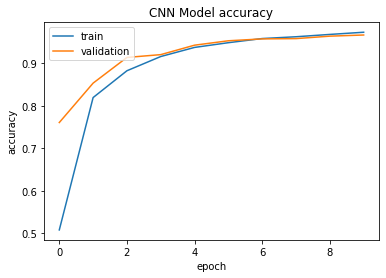

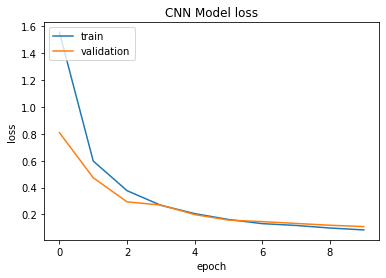

In [ ]:
# summarize history for accuracy
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('CNN Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print("")
# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('CNN Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

###Testing

In [ ]:
#function for plotting the confusion matrix taken from the lab notebook
def print_confusion_matrix_pandas(model, images, labels):
    num_classes = 13
    # Get the predicted classifications for the test-set.
    predictions = model.predict(images)
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=labels, y_pred=np.argmax(predictions,axis=1))
    cm = cm/cm.sum(axis=0, keepdims=True)
    # Plot the confusion matrix as an image.
    class_names = label_ids.keys()
    df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.axis([-0.5, 13.5, 13.5, -0.5])
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Also, we randomize the test set with the correspondent labels.

In [ ]:
# shuffle sets
test_images, test_labels = shuffle(X_test, Y_test, random_state = 2057069)

# Normalization
test_images = test_images/255.0

234/234 [==============================] - 2s 9ms/step - loss: 0.3926 - accuracy: 0.9058
Test accuracy: 0.91


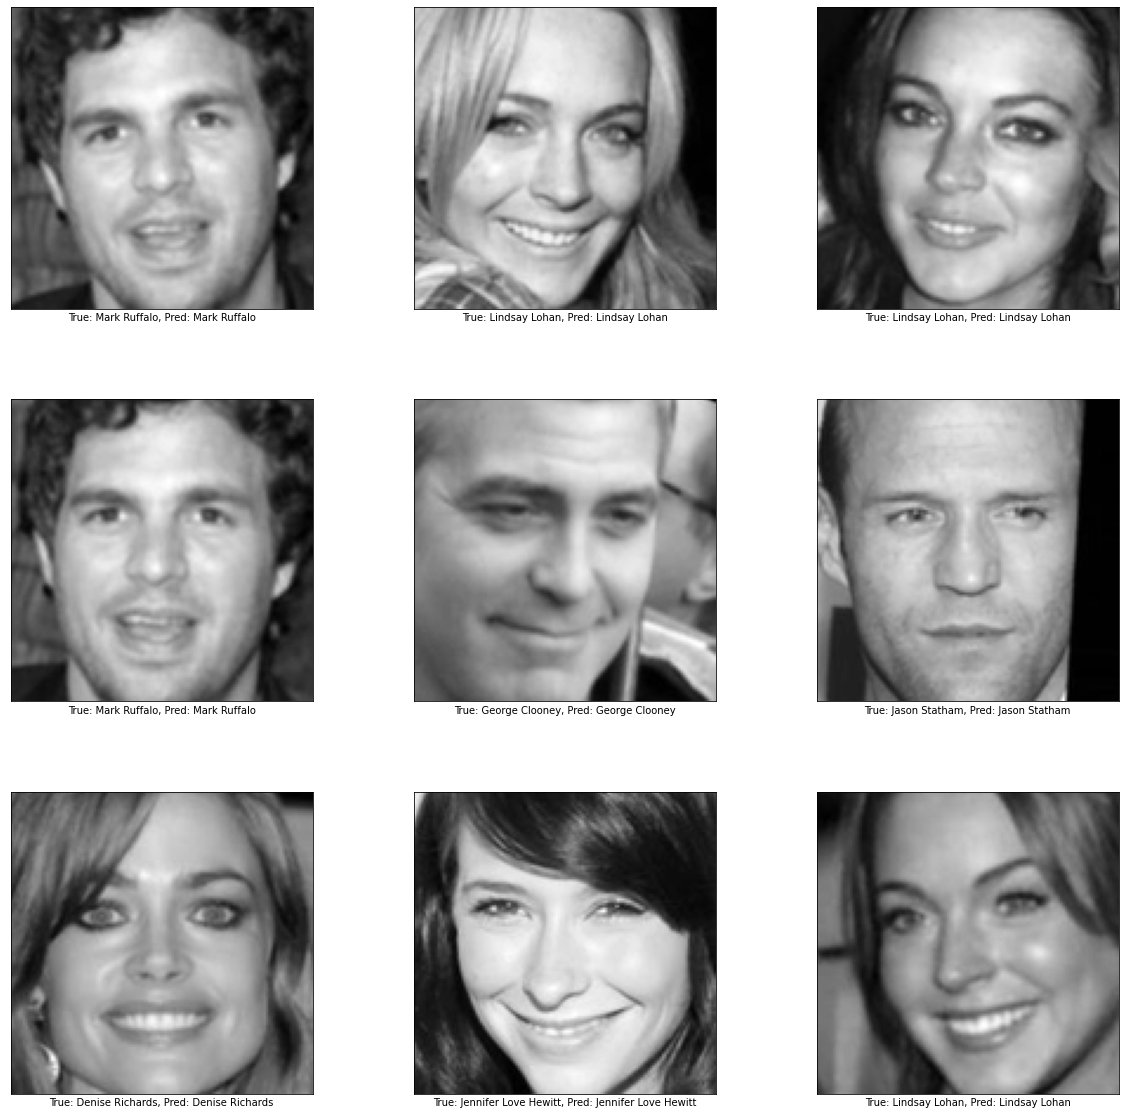

In [ ]:
# Testing Model
test_loss, test_acc = model_CNN_1.evaluate(test_images, test_labels)
print("Test accuracy: %.2f" % (test_acc))

#plotting few samples
plot_images(test_images[:9], test_labels[:9], model_CNN_1.predict(test_images[:9]), class_names)

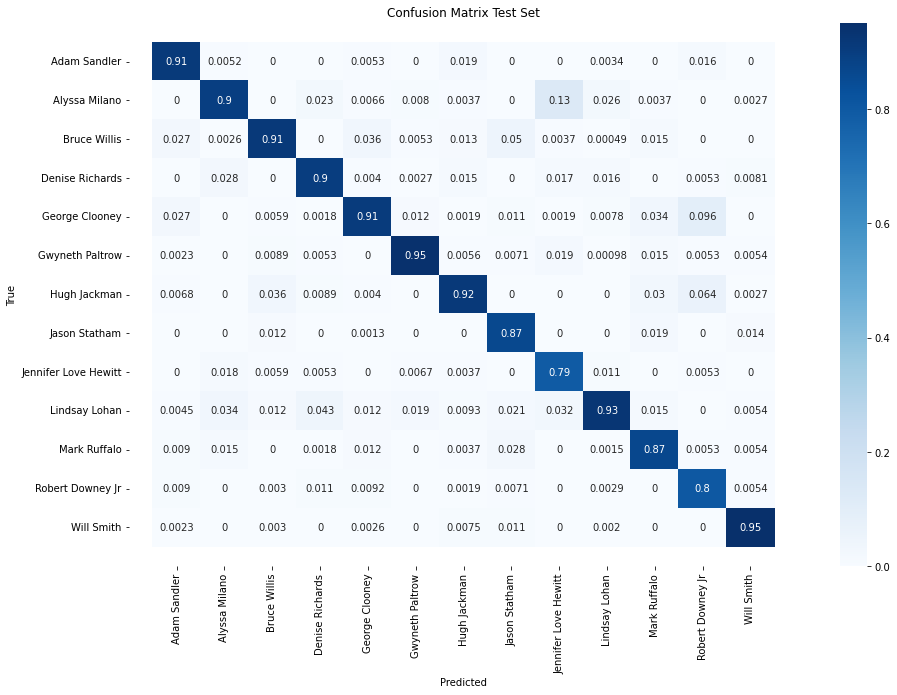

In [ ]:
#plotting confusion matrix of the model
print_confusion_matrix_pandas(model_CNN_1, test_images, test_labels)

###Discussion

The model does not overfit, as seen in the plot of the losses in the subsection of the training process (for instance, the Dropout layer has been added to prevent it). Moreover as shown after the testing procedure the accuracy on unseen data is around 91%. In the normalized Confusion Matrix it is possible to see the rates for each of the 13 classes in the dataset.

The choise for the kernel size were taken like this because in general the most important features in an image are the local ones, so a 3x3 kernel is usefull to detect them for a good feature representation, also we wanted to keep a low number of hyperparameters in the model.

Relu activation function has been selected as activatin function for the convolutional layers because it helps to prevent the growth of the model complexity.

Several models were tested but, at the end, a good test accuracy were reached with this choise of filters and with a singular Dense layer and softmax loss function and Adam optimizer.

##Faces partially covered - Comparison of performances on occluded faces

In this last part of Section 1 our goal is to see how the performances of the model are influenced by a different test set. 

We will analyze different set, in particular where part of the face is covered by glasses or masks.

The discussion is below the testing part.

###Testing

In [ ]:
#Setting the paths
X_test_glasses_path = './datasets/X_test_glasses.npy'
Y_test_glasses_path = './datasets/Y_test_glasses.npy'
X_test_sunglasses_path = './datasets/X_test_sunglasses.npy'
Y_test_sunglasses_path = './datasets/Y_test_sunglasses.npy'
X_test_mask_path = './datasets/X_test_mask.npy'
Y_test_mask_path = './datasets/Y_test_mask.npy'
X_test_facemask_path = './datasets/X_test_facemask.npy'
Y_test_facemask_path = './datasets/Y_test_facemask.npy'

In [ ]:
#Initializing data
X_test_glasses = np.load(X_test_glasses_path)
Y_test_glasses = np.load(Y_test_glasses_path)
X_test_sunglasses = np.load(X_test_sunglasses_path)
Y_test_sunglasses = np.load(Y_test_sunglasses_path)
X_test_mask = np.load(X_test_mask_path)
Y_test_mask = np.load(Y_test_mask_path)
X_test_facemask = np.load(X_test_facemask_path)
Y_test_facemask = np.load(Y_test_facemask_path)

231/231 [==============================] - 1s 6ms/step - loss: 1.7166 - accuracy: 0.6089
Test accuracy - Glasses test_set: 0.61


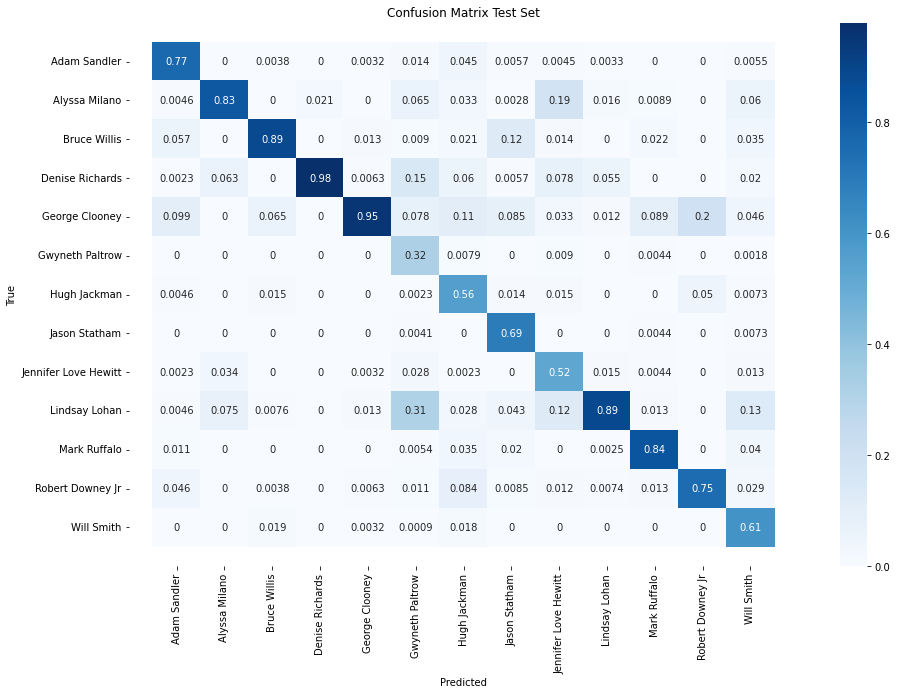

In [ ]:
# Case 1: Glasses

# shuffle sets
test_images, test_labels = shuffle(X_test_glasses, Y_test_glasses, random_state = 2057069)

# Normalization
test_images = test_images/255.0

test_loss, test_acc = model_CNN_1.evaluate(test_images, test_labels)
print("Test accuracy - Glasses test_set: %.2f" % (test_acc))

#plotting confusion matrix for Model 1
print_confusion_matrix_pandas(model_CNN_1, test_images, test_labels)

196/196 [==============================] - 1s 6ms/step - loss: 6.5371 - accuracy: 0.4225
Test accuracy - Sunglasses test_set: 0.42


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


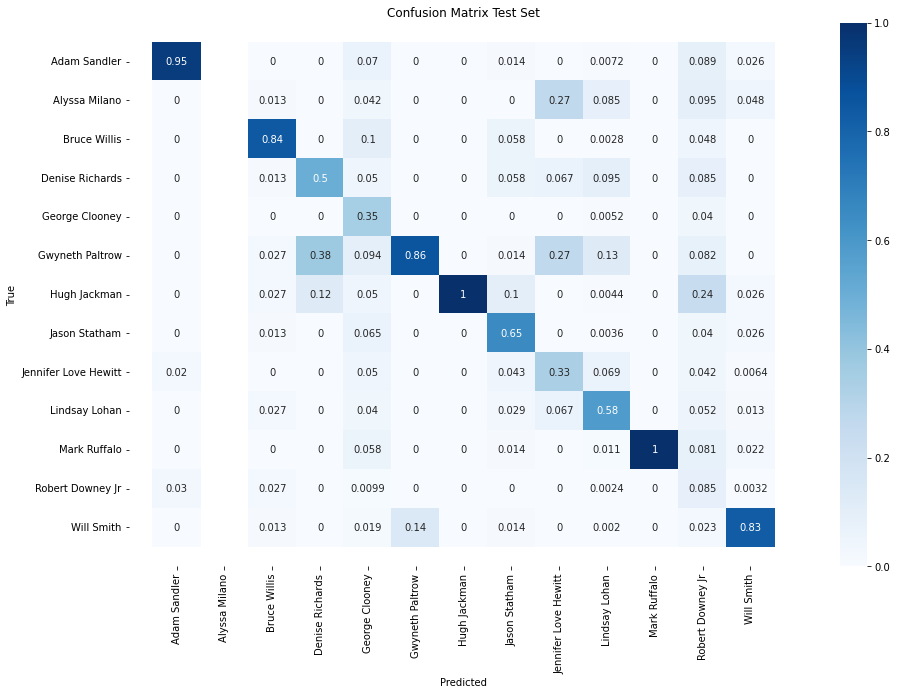

In [ ]:
# Case 2: Sunglasses

# shuffle sets
test_images, test_labels = shuffle(X_test_sunglasses, Y_test_sunglasses, random_state = 2057069)

# Normalization
test_images = test_images/255.0

test_loss, test_acc = model_CNN_1.evaluate(test_images, test_labels)
print("Test accuracy - Sunglasses test_set: %.2f" % (test_acc))

#plotting confusion matrix for Model 1
print_confusion_matrix_pandas(model_CNN_1, test_images, test_labels)

65/65 [==============================] - 0s 6ms/step - loss: 4.5540 - accuracy: 0.3551
Test accuracy - Mask test_set: 0.36


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


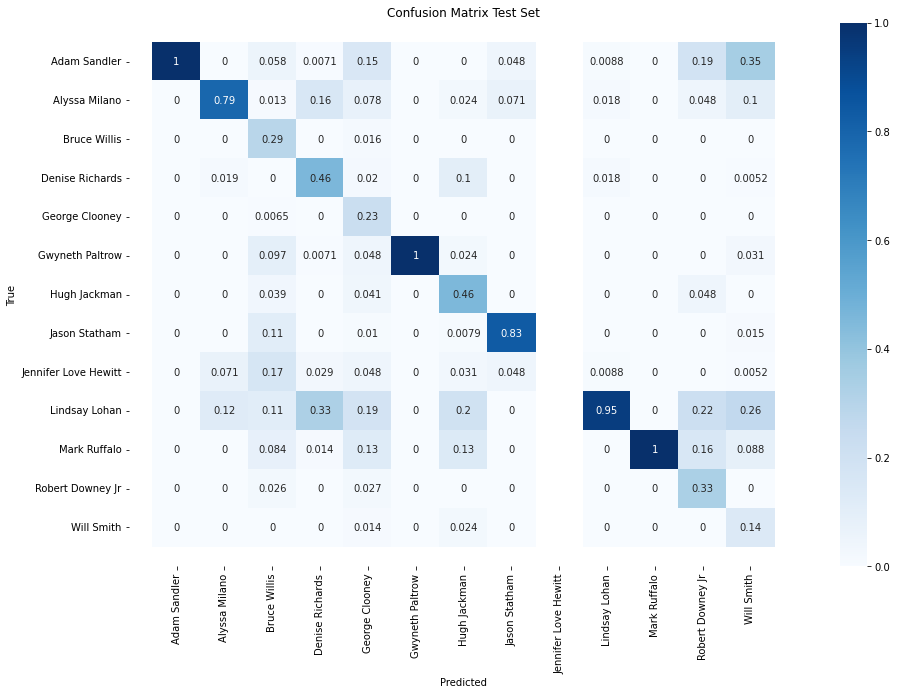

In [ ]:
# Case 3: Mask

# shuffle sets
test_images, test_labels = shuffle(X_test_mask, Y_test_mask, random_state = 2057069)

# Normalization
test_images = test_images/255.0

test_loss, test_acc = model_CNN_1.evaluate(test_images, test_labels)
print("Test accuracy - Mask test_set: %.2f" % (test_acc))

#plotting confusion matrix for Model 1
print_confusion_matrix_pandas(model_CNN_1, test_images, test_labels)

53/53 [==============================] - 0s 7ms/step - loss: 5.7617 - accuracy: 0.3393
Test accuracy - FaceMask test_set: 0.34


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


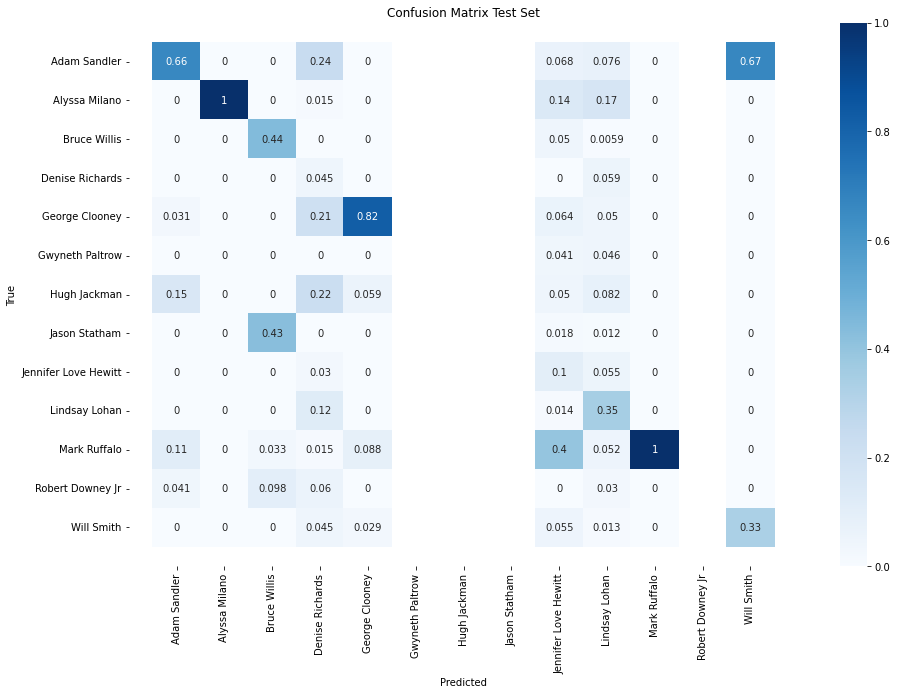

In [ ]:
# Case 4: Face Mask

# shuffle sets
test_images, test_labels = shuffle(X_test_facemask, Y_test_facemask, random_state = 2057069)

# Normalization
test_images = test_images/255.0

test_loss, test_acc = model_CNN_1.evaluate(test_images, test_labels)
print("Test accuracy - FaceMask test_set: %.2f" % (test_acc))

#plotting confusion matrix for Model 1
print_confusion_matrix_pandas(model_CNN_1, test_images, test_labels)

###Discussion

- Test set of faces with glasses: Accuracy around 61%

- Test set of faces with sunglasses: Accuracy around 42%

- Test set of faces with masks: Accuracy around 36%

- Test set of faces with facemasks: Accuracy around 34%

We can clearly see how the accuracy of the model drops down from 91% to 34% for masked faces. Obviously this is due to the fact that in the training fase of the model no masked or face with glasses were taken into account. In the end, if we take into account the losses of the model on the four dataset we can see how the value is exploding compared to the normal testing.

# **Section 2** - Applied examples of Face Detection and Recognition

With cv2 HaarCascade Filters and the model defined above, we will now extend the classification from .jpg images contained in the Dataset to the video of one celebrity.

##Face detection through the notebook camera

Firstly, we will try to see how the **_HaarCascadeClassifiers_** in the Open CV dependencies works during a live acquisition of the face through the notebook camera.

In [1]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

Firstly we define some utility functions for the detection of a face through the notebook camera. These first functions helps to connect Google Colab to our notebook camera.

In [2]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# pre-build in OpenCV 
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

The following cell contains a snippet for the camera capturing. The snippet has been taken from the ones proposed in the section of colab with helpfull snippets and has been modified to detect faces in the photo taken.

In [3]:
#Snippet pre writte in Colab taken to access the camera of the notebook from the Colab app
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Click here to take the photo';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Capture on click button
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

## Part of the code for the detection of a face using Haar Cascades

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  
  # get OpenCV format image
  img = js_to_image(data) 

  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)

  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)

  # draw face bounding box on image
  for (x,y,width,height) in faces:
      img = cv2.rectangle(img,(x,y),(x+width,y+height),(255,0,0),2)

  # save image
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


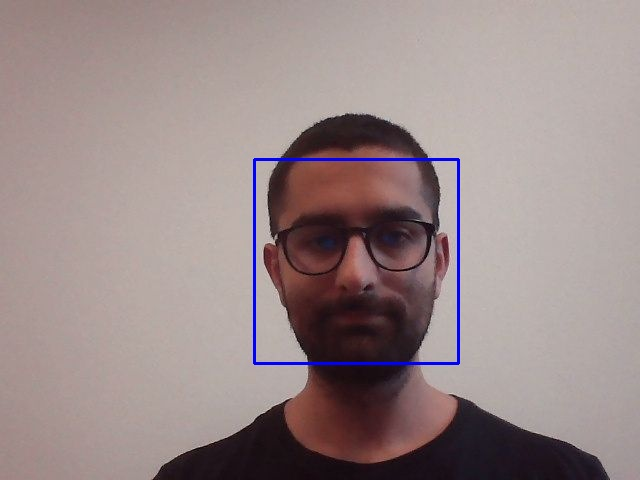

In [4]:
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
  
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str("Permission denied or no camera found"))

To access the live stream of the camera in Colab we will need some utility function more complex that the one before. References [2]

In [ ]:
# Function to display the data captured by the webcam
def video_stream():
  js = Javascript('''
  // Defining variables
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
  // Close the webcam
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
  // getting the frame from the video
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    async function createDom() {
      if (div !== null) {
        return stream;
      }
   // display video
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
   // Display info video
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
   // Command to close the video
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
   // Display info to exit program
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'Click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
   // Display info video
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      return stream;
    }
   // Stream all frames
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
#function for labeling each frame of the video
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

Once defined the functions we can see a demo of the live detection through the camera.

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Recording...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates using Haar Cascade filters defined above
    faces = face_cascade.detectMultiScale(gray)

    # drawing rectangles aroud the face
    for (x,y,width,height) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+width,y+height),(0,0,255),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

##Face detection through time: Video Analysis

In this section we will extend the face detection through time. We will analyze two video.

The first video is a clip from the Wired autocomplete interview of Bruce Willis, published on YouTube in 2018 (https://www.youtube.com/watch?v=-pwvctnQUYM). The aim is to see the prediction made by our model on the sequence of frames of the video.

The second video is a variat of the first one. It has been put a black box which covers partially the face of Bruce Willis. The aime is to see how the model will make the prediction on these frames.

***REMARK:***

The video have been uploaded from the local for connection delay while writing this project. The results are still available while reopening colab, but if you want to see the simulatin on work, the same video is available at:

- https://drive.google.com/drive/folders/1LrpQd_3Gm7p4g_yZZai0UOZbqZjgxTbx?usp=sharing

For any problem please contact francescoluigi.defaveri@studenti.unipd.it

In [ ]:
#fuction to get the label
def get_id(val, my_dict):
    for key, value in my_dict.items():
         if val == value:
             return key
 
    return "Identity doesn't exist"

In [ ]:
#importing the file video from notebook, and other usefull tools as cv2
from google.colab import files, output
from google.colab import output
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from collections import deque

###Video 1

In [ ]:
#load video
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Now we will analyze the video using cv2, frame by frame we will use the Haar Cascade filters to detect faces. 
As output of the cell below we will show the detection computed frame by frame.

In [ ]:
#diplaying original video
from IPython.display import HTML
from base64 import b64encode

mp4_2 = open('Input_1.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4_2).decode()
HTML("""
<video width=400 controls muted>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

We will analyze the video using cv2, frame by frame and we will use the Haar Cascade filters, as shown in the above subsection, to detect faces. As output of the cell below we will show the identification computed frame by frame.

In [ ]:
#getting the pre-trained filters of cv2
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
#defining the source for the detection
video_cap = cv2.VideoCapture('Input_1.mp4')

#casting usefull variables
frame_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_cap.get(cv2.CAP_PROP_FPS))

# video objet (we need to compute an .avi video just for simplicity in the coding part, 
# in the cell below the video will be re-converted in .mp4)
fourcc = cv2.VideoWriter_fourcc(*'MPEG')
output = cv2.VideoWriter('output_1.avi', fourcc, fps, (frame_width, frame_height))
#using the model defined
model = model_CNN_1
#define the classes
Q = deque(maxlen = 128)
while (True):
  # reading the video
  ret, frame = video_cap.read()
  #creating a copy of the frame for the video in output
  output_frame = frame.copy()
  
    
  # Detect faces
  faces = face_cascade.detectMultiScale(frame, 1.1, 4) #params: img, scale, min_neighb
  
  #working on the frame to convert from BGR format of cv2 to Gray scale because 
  #the model has learned on gray scale images
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

  #resizing and normalizing frame
  frame = cv2.resize(frame, (128, 128)).astype("float32")
  #giving the frame as input to the model
  preds = model.predict(np.expand_dims(frame, axis = 0))[0]
  Q.append(preds)

  #getting results
  results = np.array(Q).mean(axis = 0)
  i = np.argmax(results)
  label = get_id(i, label_ids)
  text = "Identity: {}".format(label)
  #working on the video in output
  if(ret):
    # detection with pretrained filters
    faces = face_cascade.detectMultiScale(output_frame)

    # draw the rectangle around the detected faces and displaying the identity of the subject
    for (x,y,width,height) in faces:
      output_frame = cv2.rectangle(output_frame,(x,y),(x+width,y+height),(255,0,0),2)
      #display the name
      output_frame = cv2.putText(output_frame, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255, 0, 0), 3)

    #writing video as sequence of frames
    #and display each of the frames that has been modified
    output.write(output_frame)
    cv2_imshow(output_frame)
  
  else:
    break
  
cv2.destroyAllWindows()
output.release()
video_cap.release()
#at the end of the work, the cell will stop with a error because since the video
#will be ended frame will be NoneType, nevertheless the modified frames will be 
#available for the execution of the next cell
#time of execution with GPU around 2 and a half minutes

In [ ]:
#converting video 2 from .avi to .mp4
!ffmpeg -i output_1.avi output_1.mp4

Here it is the resulting video.

In [ ]:
mp4 = open('output_1.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

We can see that the detection in this first video is clear and stable. Also, we have that the model does the correct prediction of the actor.

Some detection are not made exactly in the face of the actor probably because of the parameters of scale factore and minNeighbors in the cv2 function of pretraied filters and the frame rate of the video.


###Video 2


Now we upload the same video but this time to obscure the face it has been used a black box using https://www.kapwing.com/

In [ ]:
#load video
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
#diplaying original video
from IPython.display import HTML
from base64 import b64encode

mp4_2 = open('Input_2.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4_2).decode()
HTML("""
<video width=400 controls muted>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Same procedure as before.

In [ ]:
#getting the pre-trained filters of cv2
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
#defining the source for the detection
video_cap = cv2.VideoCapture('Input_2.mp4')

#casting usefull variables
frame_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_cap.get(cv2.CAP_PROP_FPS))

# video objet (we need to compute an .avi video just for simplicity in the coding part, 
# in the cell below the video will be re-converted in .mp4)
fourcc = cv2.VideoWriter_fourcc(*'MPEG')
output = cv2.VideoWriter('output_2.avi', fourcc, fps, (frame_width, frame_height))

#using the model defined
model = model_CNN_1
#define the structure to append the frame, maxlen is the size
Q = deque(maxlen = 128)

while (True):
  # reading the video
  ret, frame = video_cap.read()
  #creating a copy of the frame for the video in output
  output_frame = frame.copy()
  
    
  # Detect faces
  faces = face_cascade.detectMultiScale(frame, 1.1, 4)
  
  #working on the frame to convert from BGR format of cv2 to Gray scale because 
  #the model has learned on gray scale images
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

  #resizing and normalizing frame
  frame = cv2.resize(frame, (128, 128)).astype("float32")
  #giving the frame as input to the model
  preds = model.predict(np.expand_dims(frame, axis = 0))[0]
  Q.append(preds)

  #getting results
  results = np.array(Q).mean(axis = 0)
  i = np.argmax(results)
  label = get_id(i, label_ids)
  text = "Identity: {}".format(label)
  
  #working on the video in output
  if(ret):
    # detection with pretrained filters
    faces = face_cascade.detectMultiScale(output_frame)

    # draw the rectangle around the detected faces and displaying the identity of the subject
    for (x,y,width,height) in faces:
      output_frame = cv2.rectangle(output_frame,(x,y),(x+width,y+height),(255,0,0),2)
      #display the name
      output_frame = cv2.putText(output_frame, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255, 0, 0), 3)

    #writing video as sequence of frames
    #and display each of the frames that has been modified
    output.write(output_frame)
    cv2_imshow(output_frame)
  
  else:
    break
  
cv2.destroyAllWindows()
output.release()
video_cap.release()
#at the end of the work, the cell will stop with a error because since the video
#will be ended frame will be NoneType, nevertheless the modified frames will be 
#available for the execution of the next cell
#time of execution with GPU around 2 and a half minutes

Converting the video to .mp4 format

In [ ]:
#converting video 2 from .avi to .mp4
!ffmpeg -i output_2.avi output_2.mp4

Here it is the result.

In [ ]:
mp4 = open('output_2.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

We clearly can see how the model miss the recognition in the majority of the frames the recognition is not done due to the black box which cover the face.

In some frames, where the black box is not covering some crucial feature of the face the detection and the recognition is done correctly as seen below (this fact probably depends to the minNeighbors parameter of the cv2 function for the detection).

![](https://drive.google.com/uc?export=view&id=1Q4OC4Ptfr2GxYSs_vTCrX2pRvJbspTui)


# **Section 3** - Face Recogition with AlexNet


##AlexNet


We now implement the structure of AlexNet.

***Remark:***

The real structure of AlexNet is slightly different from the one reported below. This version has been made so that the input layer could take the images of the dataset, which are 128x128 and grayscale, so not as 224x224 in RGB format.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization

We define and compile the model.

After that we plot the summary to see the architecture of AlexNet

In [ ]:
model_AlexNet = Sequential()

#CONVOLUTIONAL PART
#1 Conv Layer
model_AlexNet.add(Conv2D(input_shape=(128,128,1), kernel_size=(11,11), filters=96, strides = (4,4), padding="same", activation="relu"))
model_AlexNet.add(BatchNormalization())
model_AlexNet.add(MaxPooling2D(pool_size = (2,2), strides = (2,2), padding="same"))
#2 Conv Layer
model_AlexNet.add(Conv2D(kernel_size=(5,5), filters=256, strides = (1,1), padding="same", activation="relu"))
model_AlexNet.add(BatchNormalization())
model_AlexNet.add(MaxPooling2D(pool_size = (2,2), strides = (2,2), padding="same"))
#3 Conv Layer
model_AlexNet.add(Conv2D(kernel_size=(3,3), filters=384, strides = (1,1), padding="same", activation="relu"))
model_AlexNet.add(BatchNormalization())
#4 Conv Layer
model_AlexNet.add(Conv2D(kernel_size=(3,3), filters=384, strides = (1,1), padding="same", activation="relu"))
model_AlexNet.add(BatchNormalization())
#5 Conv Layer
model_AlexNet.add(Conv2D(kernel_size=(3,3), filters=256, strides = (1,1), padding="same", activation="relu"))
model_AlexNet.add(BatchNormalization())
model_AlexNet.add(MaxPooling2D(pool_size = (2,2), strides = (2,2), padding="same"))

#DENSE PART
#1 Dense Layer
model_AlexNet.add(Flatten())
model_AlexNet.add(Dense(units = 4096, activation = 'relu'))
model_AlexNet.add(BatchNormalization())
model_AlexNet.add(Dropout(0.4))
#2 Dense Layer
model_AlexNet.add(Dense(units = 4096, activation = 'relu'))
model_AlexNet.add(BatchNormalization())
model_AlexNet.add(Dropout(0.4))
#3 Dense Layer
model_AlexNet.add(Dense(units = 1000, activation = 'relu'))
model_AlexNet.add(BatchNormalization())
model_AlexNet.add(Dropout(0.4))

#OUTPUT PART
model_AlexNet.add(Dense(units = 13, activation = 'softmax'))

model_AlexNet.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model_AlexNet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 96)        11712     
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 96)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 256)      1024      
 hNormalization)                                                 
                                                      

##Training AlexNet

We now train AlexNet model with the same parameters as before.

In [ ]:
history = model_AlexNet.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

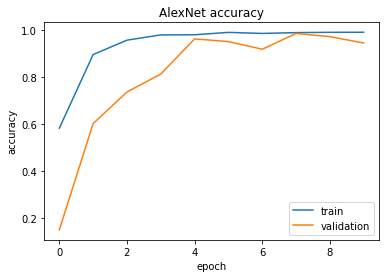

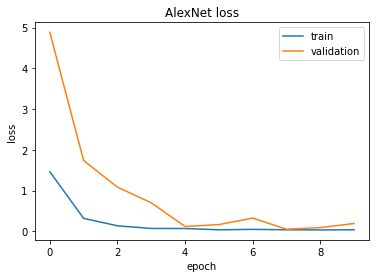

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('AlexNet accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('AlexNet loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

##Testing AlexNet

To conclude, we test the model on the test set, the we plot the confusion matrix.

234/234 [==============================] - 3s 10ms/step - loss: 0.7978 - accuracy: 0.8339
Test accuracy: 0.83


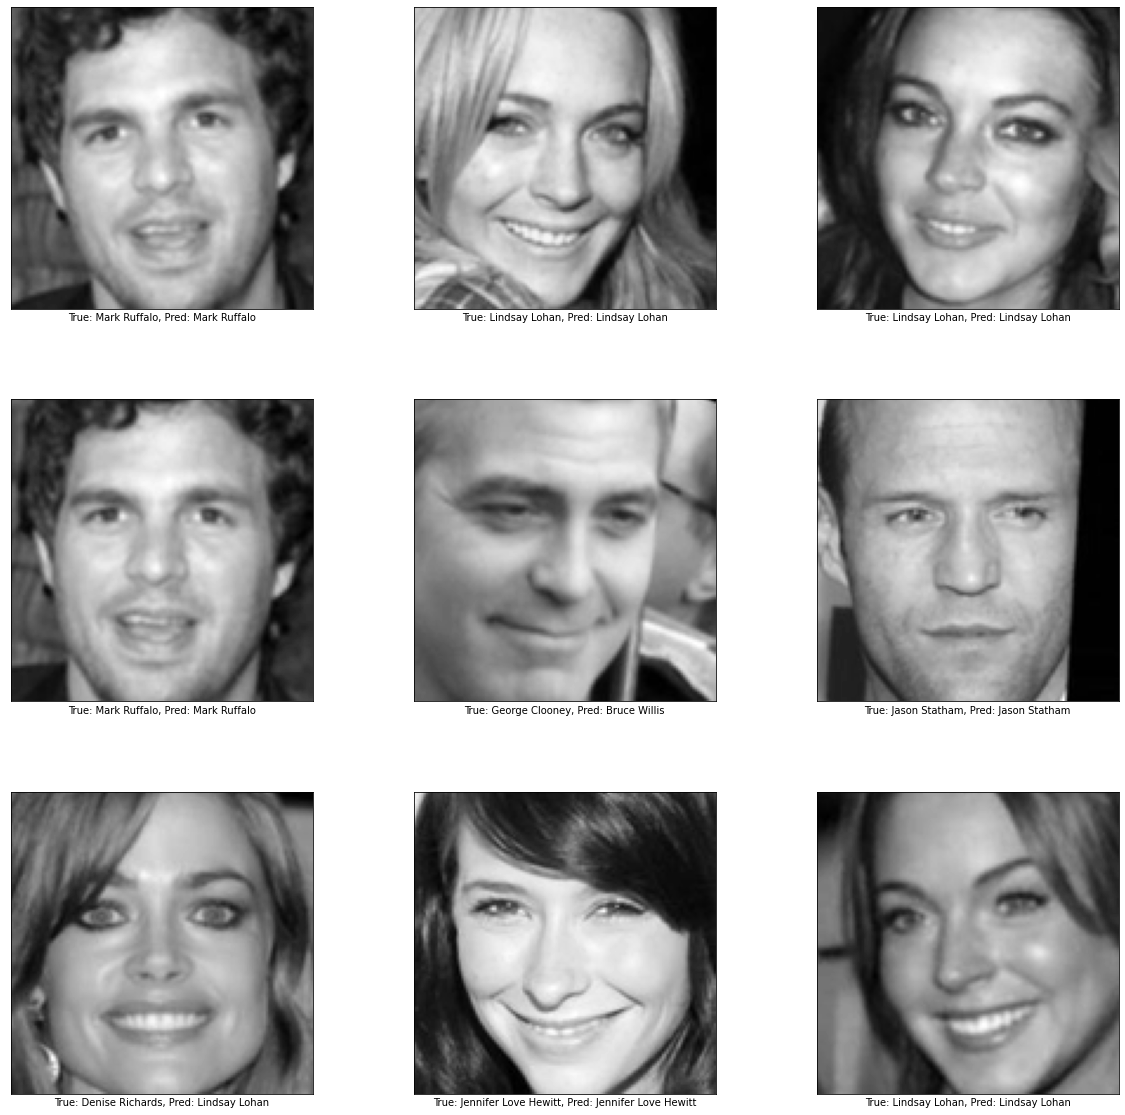

In [ ]:
X_test_path = './datasets/X_test.npy'
Y_test_path = './datasets/Y_test.npy'
X_test = np.load(X_test_path)
Y_test = np.load(Y_test_path)

# shuffle sets
test_images, test_labels = shuffle(X_test, Y_test, random_state = 2057069)

# Normalization
test_images = test_images/255.0
# Testing Model
test_loss, test_acc = model_AlexNet.evaluate(test_images, test_labels)
print("Test accuracy: %.2f" % (test_acc))

#plotting few samples
plot_images(test_images[:9], test_labels[:9], model_AlexNet.predict(test_images[:9]), class_names)

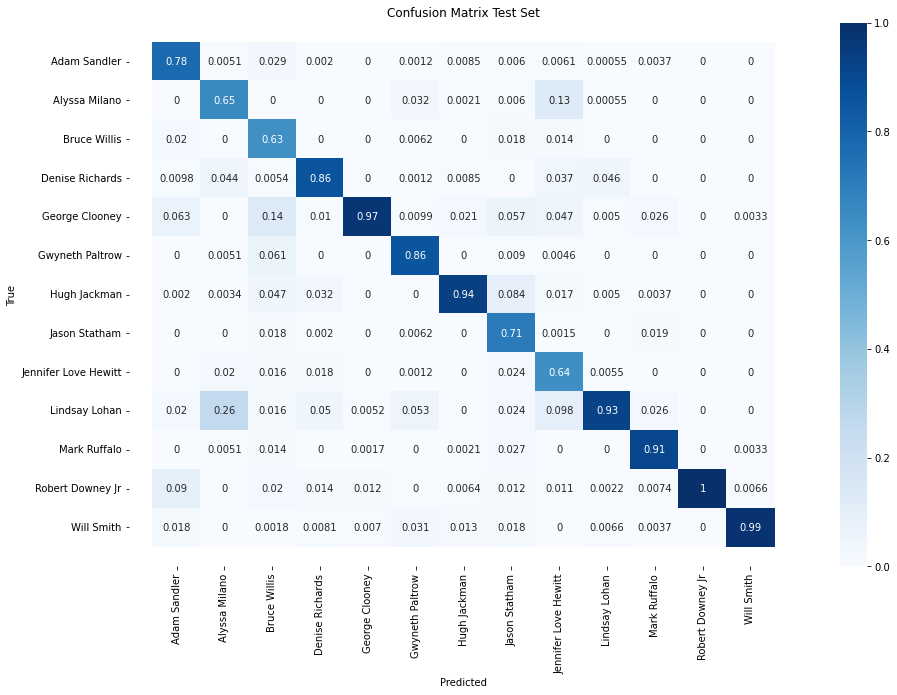

In [ ]:
#plotting confusion matrix of the model
print_confusion_matrix_pandas(model_AlexNet, test_images, test_labels)

We see that the AlexNet architecture does not improve the accuracy on the test set, moreover the plot of the loss/valid_loss and accuracy/valid_accuracy is more irregular than before.

# References


[1]   Section 1: Lab4 Experience

[2]   Section 2: https://docs.opencv.org/4.x/index.html & https://github.com/theAIGuysCode/colab-webcam 

[3]   Section 3: https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/ & https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf
